# Multi-layer Perceptron: Learning by Error-Backpropagation

# Overview
This Jupyter Notebook goes through a simple simulation of a multi-layer perceptron that learns how to map inputs to outputs using error backpropagation.

In [ ]:
# Libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [ ]:
# Function 1: trainnet_perceptron
#-----------------------------------------------------------------
# Trains a network on desired input and output mappings using the delta
# learning rule with specified growth rate and momentum. Input activation is
# propagated through the network each iteration using the logistic activation
# function. The actual output is compared to the desired output. The error
# indicates how much the connection weights through each layer should change
# using the generalized delta rule. These weight changes are backpropagated
# through each layer.
#
# Returns a list of weights, Wt, over all training epochs (decided by user),
# and total network error, toterr, over epochs.
#
# Usage:
#
# trainnet_perceptron(W,input,dout,unitslayer,epochs,err,eta,mu)
#
# W           - List of connection weight matrices for each layer of connections.
#               This is initialized as a matrix of random weights for each
#               layer if set as NULL.
# input       - Array of input patterns (rows: units; columns: patterns)
# dout        - Array of desired output pattern (rows: units; columns: patterns)
# unitslayers - Vector of number of units in each layer of units
# epochs      - Number of cycles before network stops training
# err         - Error threshold below which to stop training
# eta         - Growth rate, blame
# mu          - Momentum

def trainnet_perceptron(W,input,dout,unitslayer,epochs,err,eta,mu):

  # Initialize parameters
  ninput    = np.shape(input)[1]       # No. of input units
  npats     = np.shape(input)[0]       # No. of training patterns
  nlayers   = np.size(unitslayer) - 1  # No. of connection layers
  Wt        = [0]                      # Weights over epochs
  hWt       = [0]                      # Held weights over epochs
  toterr    = [err + 10]               # Set arbitrary start total network error

  # Add bias units
  for i in range(nlayers):
    unitslayer[i] = unitslayer[i] + 1

  # Initialize W and hold W matrices
  if W is None:

    W            = []
    holdpatternW = []

    # Initialize connection layers
    for k in range(nlayers):
      hW  = np.random.uniform(-1,1,(unitslayer[k],unitslayer[k+1]))
      hhW = np.zeros((unitslayer[k],unitslayer[k+1]))

      # Remove connection to next layer bias unit
      if k != nlayers-1:
        hW[:,unitslayer[k+1]-1]=0
        hhW[:,unitslayer[k+1]-1]=0

      W.append(hW)
      holdpatternW.append(hhW)

  else:

    holdpatternW = []

    # Initialize connection layers
    for k in range(nlayers):
      hhW = np.zeros((unitslayer[k],unitslayer[k+1]))

      # Check and remove connection to next layer bias unit
      if k != nlayers-1:
        if unitslayer[k+1]==np.shape(W[k])[1]:
          W[k][:,unitslayer[k+1]-1]=0

      holdpatternW.append(hhW)

  zeroholdpatternW=holdpatternW.copy()

  # End W initialization

  # Train W
  for t in range(epochs):   # Epoch loop
    if toterr[t]>=err:      # Error loop

      # Set parameters
      paterr     = []

      # Momentum term
      M = []
      for k in range(nlayers):
        M.append(holdpatternW[k]*mu)

      holdpatternW = zeroholdpatternW.copy()
      holdlayerW = [np.empty_like(w) for w in holdpatternW]

      # Learn weight changes for each pattern (but do not apply yet)
      for p in range(npats):

        # Set parameters
        ai      = []
        ai.append(input[p,:])

        # Feedforward: Propagate activity
        for k in range(nlayers):

          # Set bias input unit activation to 1
          if k == 0:
            ai[k] = np.append(ai[k],1)
          else:
            ai[k][-1] = 1

          # Logistic activation function
          net_input = np.dot(ai[k],W[k])
          ai.append(scipy.special.expit(net_input))

        # Backprop: Calculate change in weights
        error = [np.empty(unitslayer[k+1]) for k in range(nlayers)]

        for k in range(nlayers,0,-1):

          # For output layer
          if k==nlayers:

            # Calculate output unit error
            error[k-1]=(dout[p,:]-ai[k])*ai[k]*(1-ai[k]) #??

            # Calculate pattern error
            paterr.append(sum((dout[p,:]-ai[k])**2))

            # Calculate layer weight change
            holdlayerW[k-1]=eta*np.outer(np.transpose(ai[k-1]),error[k-1]) #??

          # For hidden layers
          else:

            # Calculate hidden unit error
            error[k-1]=np.dot(error[k],np.transpose(W[k]))*ai[k]*(1-ai[k])

            # Calculate layer weight change
            holdlayerW[k-1]=eta*np.outer(np.transpose(ai[k-1]),error[k-1]) #??

            # Account for bias unit
            holdlayerW[k-1][:,unitslayer[k]-1]=0

        # Sum pattern dW
        for l in range(len(holdlayerW)):
          holdpatternW[l] = holdlayerW[l] + holdpatternW[l]

      # Batch add dW to original weights W
      Wtemp = W.copy()
      for l in range(len(W)):
        W[l] = Wtemp[l] + holdpatternW[l] + M[l]

      # Calculate total error across patterns
      toterr.append(sum(paterr))

      # Update variables over epochs
      Wt.append(W[:])

  return Wt, toterr

In [ ]:
# Function 2: testnet_perceptron
#-----------------------------------------------------------------
# Tests a trained perceptron network, W, for the output, a, given
# an input. Each unit state is determined using a logistic activation
# function. Returns a, a vector of activation states for each layer
# of units including the input layer.
#
# Usage:
#
# testnet_perceptron(W,input,unitslayer)
#
# W          - Trained connection weight matrix, must be list format
#	           (see trainnet_perceptron.R)
# input      - Test pattern vector (units: rows)
# unitslayer - Vector of number of units in each layer of units

def testnet_perceptron(W,input,unitslayer):

  # Set parameters
  Wc = W.copy()
  nlayers = len(Wc) # No. of connection layers
  a = [input.copy()]

  # Feedforward
  for k in range(nlayers):

    # Select non-bias weights in network
    Wc_temp = Wc[k].copy()
    Wc[k] = Wc_temp[0:np.shape(Wc[k])[0]-1]

    # Logistic activation function on non-bias units
    if k != nlayers-1:
      net_input = np.dot(a[k],Wc[k])[0:np.shape(Wc[k])[1]-1]
    else:
      net_input = np.dot(a[k],Wc[k])
    a.append(scipy.special.expit(net_input))

  return a

In [ ]:
# Distort input vectors
def distort_pattern(a,p):

  ap = a.copy()
  for unit in range(np.shape(ap)[0]-1):
    if np.random.uniform(0,1,1)<=p:
      if ap[unit]==1:
        ap[unit]=0
      else:
        ap[unit]=1

  return ap

In [ ]:
# Plotting setup
def plot_toterr(toterr):
  plt.plot(toterr)
  plt.title("Total error timecourse")
  plt.xlabel("Iteration")
  plt.ylabel("Total Error")

In [ ]:
# Training input activation patterns using non-overlapping categories
# Input
a = np.array([[0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,1],
              [0,0,0,1,0,0,0,0,1,0],
              [0,0,1,0,0,0,0,1,0,0],
              [0,1,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0]])

# Desired output
o = np.array([[1,0,0,0],
              [1,0,0,0],
              [0,1,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,1,0],
              [0,0,0,1],
              [0,0,0,1]])

# Hyperparameters
epochs = 100000
err    = 0.001
eta    = 0.3 # learning rate
mu     = 0.7 # alpha, momentum

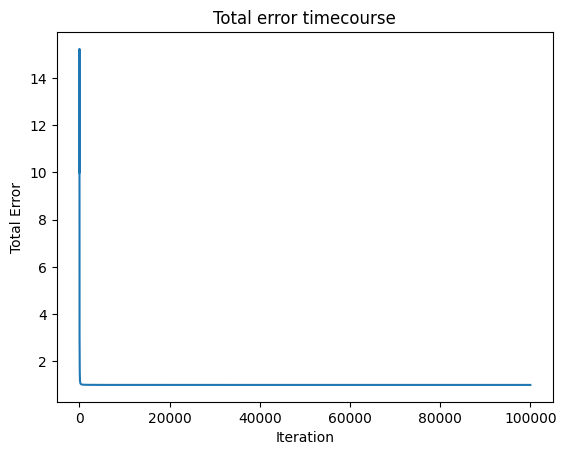

In [ ]:
Wt,toterr=trainnet_perceptron(None,a,o,[10,20,4],epochs,err,eta,mu)
plot_toterr(toterr)

In [ ]:
testnet_perceptron(Wt[-1],a[0],[10,20,4])

[array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0.66367054, 0.28339011, 0.11234262, 0.38036512, 0.34167191,
        0.28346374, 0.75891734, 0.5208368 , 0.87423833, 0.12668377,
        0.64391807, 0.80603908, 0.75644991, 0.39809443, 0.79144723,
        0.3329741 , 0.54526934, 0.21175048, 0.20442063, 0.50821945]),
 array([0.99849887, 0.00560453, 0.00886128, 0.00274654])]